In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jaxlie import SE3, SO3
import jax_dataclasses as jdc
from functools import partial

from sdf_world.sdf_world import *
from sdf_world.robots import *
from sdf_world.util import *
from sdf_world.network import *

from flax import linen as nn
from flax.training import orbax_utils
import orbax
import pickle
import time

### Load models

In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_grasp = orbax_checkpointer.restore("model/grasp_net_prob_dist")
restored_manip = orbax_checkpointer.restore("model/manip_net_posevec")

#grasp net
grasp_net = GraspNet(32)
grasp_fn = lambda x: grasp_net.apply(restored_grasp["params"], x)
def grasp_reconst(g:Array, obj_pose:SE3):
    rot = SO3(grasp_fn(g)[2:]).normalize()
    trans = g/restored_grasp["scale_to_norm"]
    return obj_pose @ SE3.from_rotation_and_translation(rot, trans)
grasp_logit_fn = lambda g: grasp_fn(g)[0]
grasp_dist_fn = lambda g: grasp_fn(g)[1]
#manip net
manip_net = ManipNet(64)
manip_fn = lambda x: manip_net.apply(restored_manip["params"], x)[0]

### Load world

In [3]:
world = SDFWorld()
panda_model = RobotModel(PANDA_URDF, PANDA_PACKAGE)
panda = Robot(world.vis, "panda", panda_model, alpha=0.5)
panda.reduce_dim([7, 8], [0.04, 0.04])

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [4]:
world.show_in_jupyter()

In [5]:
frame = Frame(world.vis, "frame")

In [6]:
table_lengths = [0.4, 0.4, 0.2]
table_start = Box(world.vis, "table_start", table_lengths, 'white', 0.5)
table_goal = Box(world.vis, "table_goal", table_lengths, 'white', 0.5)
obj_start = Mesh(world.vis, "obj_start", 
                 "./sdf_world/assets/object/mesh.obj",
                 color="blue",
                 alpha=0.5)
obj_goal = Mesh(world.vis, "obj_goal", 
                "./sdf_world/assets/object/mesh.obj",
                color="green",
                 alpha=0.5)

In [7]:
table_start.set_translate([0.5, -0.3, 0.2/2])
table_goal.set_translate([0.5, 0.3, 0.2/2])
obj_lengths = obj_start.mesh.bounding_box.primitive.extents
obj_start.set_translate([0.5, -0.3, obj_lengths[-1]/2+table_lengths[-1]])
trans_goal = jnp.array([0.5, 0.3, obj_lengths[-2]/2+table_lengths[-1]])
obj_goal_pose = SE3.from_rotation_and_translation(
    SO3.from_rpy_radians(jnp.pi/2, 0,0), trans_goal
)
obj_goal.set_pose(obj_goal_pose)

In [8]:
hand_model = RobotModel(HAND_URDF, PANDA_PACKAGE, True)
for link_name, link in hand_model.links.items():
    link.set_surface_points(10)
hand1 = Robot(world.vis, "hand1", hand_model, color="yellow", alpha=0.5)

In [70]:
hand_pc = hand1.get_surface_points_fn(jnp.array([0.04, 0.04]))
hand_pose_wrt_ee = SE3.from_translation(jnp.array([0,0,-0.105]))
env = SDFContainer([table_start, table_goal], 0.05)
# x -> grasps
@jax.jit
def get_hand_points(x, obj_pose1, obj_pose2):
    result = []
    for pose in [obj_pose1, obj_pose2]:
        grasp_pose = grasp_reconst(x, pose)
        hand_base_pose_wrt_world = grasp_pose @ hand_pose_wrt_ee
        assigned_hand_pc = jax.vmap(hand_base_pose_wrt_world.apply)(hand_pc)
        result.append(assigned_hand_pc)
    return jnp.vstack(result)

@jax.jit
def distance_constr(x):
    hand_pcs = get_hand_points(x, obj_start.pose, obj_goal.pose)
    distances = env.distances(hand_pcs)
    top4_indices = jnp.argpartition(distances, 4)[:4]
    return distances[top4_indices]

In [17]:
distance_constr(jnp.zeros(3))

Array([0.04241648, 0.05189609, 0.05315753, 0.0552799 ], dtype=float32)

In [ ]:
pc = PointCloud(world.vis, "hand_pc", hand_pcs, color="red")

In [21]:
x = jnp.array([0,0,-0.5])
hand_pcs = get_hand_points(x, obj_start.pose, obj_goal.pose)

In [22]:
pc.reload(points=hand_pcs)

In [28]:
jax.jacrev(distance_constr)(x)

Array([[ 3.5256162e-02,  2.1736976e-02, -2.5891137e-01],
       [ 1.7272830e-01, -5.9932470e-04, -1.8686862e-01],
       [-3.7253952e-01, -2.3437455e-02,  8.9211464e-01],
       [-2.0955594e-01, -4.9258277e-02,  6.5949869e-01]], dtype=float32)

In [29]:
to_posevec = lambda x: jnp.hstack([x[4:], SO3(x[:4]).log()])
to_wxyzxyz = lambda x: jnp.hstack([SO3.exp(x[3:]).parameters(), x[:3]])

In [30]:
frame.set_pose(grasp_reconst(x, obj_start.pose))

In [65]:
def grasp_to_manip(x, obj_pose):
    posevec = to_posevec(grasp_reconst(x, obj_pose).parameters())
    
    zflip = (SO3.exp(posevec[3:]) @ SO3.from_z_radians(jnp.pi)).log()
    posevec_flip = jnp.hstack([posevec[:3], zflip])
    return jnp.maximum(manip_fn(posevec), manip_fn(posevec_flip))

In [40]:
x = jnp.zeros(3)

In [74]:
import time
# x-> manip
def objective(x):
    frame.set_pose(grasp_reconst(x, obj_start.pose))
    hand_pcs = get_hand_points(x, obj_start.pose, obj_goal.pose)
    pc.reload(points=hand_pcs)
    time.sleep(0.05)
    return 0.

def constraints(x):
    logit = grasp_logit_fn(x)
    manip = grasp_to_manip(x, obj_start.pose)
    dists = distance_constr(x)
    return jnp.hstack([logit, manip, dists])

def jacobian(x):
    jac_logit = jax.grad(grasp_logit_fn)(x)
    jac_manip = jax.grad(grasp_to_manip)(x, obj_start.pose)
    jac_dists = jax.jacrev(distance_constr)(x)
    return jnp.vstack([jac_logit, jac_manip, jac_dists])

In [75]:
import cyipopt

### First problem

In [81]:
class Prob:
    pass
prob = Prob()
lb = -np.ones(3)
ub = np.ones(3)
setattr(prob, "objective", objective)
setattr(prob, "gradient", lambda x: np.zeros(3))
setattr(prob, "constraints", constraints)
setattr(prob, "jacobian", jacobian)
ipopt = cyipopt.Problem(
    n=3, m=6,
    problem_obj = prob,
    lb=lb, ub=ub,
    cl=[1., 0.5, 0.05, 0.05, 0.05, 0.05], 
    cu=[np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
)
ipopt.add_option("acceptable_iter", 2)
ipopt.add_option("acceptable_tol", 1.) #release
ipopt.add_option("acceptable_obj_change_tol", 0.001)
ipopt.add_option("acceptable_dual_inf_tol", 1.) 
ipopt.add_option('mu_strategy', 'adaptive')
xsol, info = ipopt.solve(jnp.array([0., -0.5, 0.5]))

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       18
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        6
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.85e+01 9.69e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00 

### Second prob

In [92]:
# Kinematics
def get_rotvec_angvel_map(v):
    def skew(v):
        v1, v2, v3 = v
        return jnp.array([[0, -v3, v2],
                        [v3, 0., -v1],
                        [-v2, v1, 0.]])
    vmag = jnp.linalg.norm(v)
    vskew = skew(v)
    return jnp.eye(3) \
        - 1/2*skew(v) \
        + vskew@vskew * 1/vmag**2 * (1-vmag/2 * jnp.sin(vmag)/(1-jnp.cos(vmag)))

@jax.jit
def get_ee_fk_jac(q):
    # outputs ee_posevec and analytical jacobian
    fks = panda_model.fk_fn(q)
    p_ee = fks[-1][-3:]
    rotvec_ee = SO3(fks[-1][:4]).log()
    E = get_rotvec_angvel_map(rotvec_ee)
    jac = []
    for posevec in fks[1:8]:
        p_frame = posevec[-3:]
        rot_axis = SE3(posevec).as_matrix()[:3, 2]
        lin_vel = jnp.cross(rot_axis, p_ee - p_frame)
        jac.append(jnp.hstack([lin_vel, rot_axis]))
    jac = jnp.array(jac).T
    jac = jac.at[3:, :].set(E @ jac[3:, :])
    return jnp.hstack([p_ee, rotvec_ee]), jac

In [88]:
x = panda.neutral.copy()

In [107]:
ee_d = to_posevec(grasp_reconst(xsol, obj_start.pose).parameters())
def objective(x):
    panda.set_joint_angles(x)
    time.sleep(1.)
    return 0.

def constraints(x):
    ee, _  = get_ee_fk_jac(x)
    fk_err = ee_d - ee
    return jnp.hstack([fk_err])

def jacobian(x):
    _, jac = get_ee_fk_jac(x)
    return - jac

In [108]:
class Prob:
    pass
prob = Prob()
lb = panda.lb
ub = panda.ub
setattr(prob, "objective", objective)
setattr(prob, "gradient", lambda x: np.zeros(7))
setattr(prob, "constraints", constraints)
setattr(prob, "jacobian", jacobian)
ipopt = cyipopt.Problem(
    n=7, m=6,
    problem_obj = prob,
    lb=lb, ub=ub,
    cl=np.zeros(6), 
    cu=np.zeros(6)
)
ipopt.add_option("acceptable_iter", 2)
ipopt.add_option("acceptable_tol", 1.) #release
ipopt.add_option("acceptable_obj_change_tol", 0.001)
ipopt.add_option("acceptable_dual_inf_tol", 1.) 
ipopt.add_option('mu_strategy', 'adaptive')
qsol, info = ipopt.solve(x)

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:       42
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        7
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.51e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [90]:
to_posevec(grasp_reconst(xsol, obj_start.pose).parameters())

Array([ 0.49778306, -0.22459584,  0.3962106 ,  1.2607896 ,  1.3556452 ,
       -1.0971388 ], dtype=float32)

In [1713]:
grasp_logit_fn(xsol)
grasp_to_manip(xsol, obj_start.pose)

Array(0.7889, dtype=float32)

In [1635]:
manip_fn(xsol)

Array(7.383164e-12, dtype=float32)

In [1624]:
frame.set_pose(SE3(to_wxyzxyz(xsol)))

Array([ 0.47850522,  0.31533492,  0.5814109 ,  1.5173137 , -0.26406425,
        0.7890735 ], dtype=float32)

In [1600]:
random_rot = SO3(np.random.normal(size=4)).normalize()
x = jnp.hstack([x[:3], random_rot.log()])
#x = jnp.hstack([random_rot.parameters(), x[-3:]])
frame.set_pose(SE3(to_wxyzxyz(x)))

In [1616]:

x = x + jnp.linalg.pinv(hess_manip(x)) @ grad_manip(x) * 0.05

frame.set_pose(SE3(to_wxyzxyz(x)).normalize())
#frame.set_pose(SE3(x).normalize())
print(val_manip(x))
print(grad_manip(x))
#print(SO3.exp(x[3:]).parameters())

0.7231313
[ 0.00606303 -0.29821372 -0.11448995 -0.08337639  0.10807732  0.00948917]


In [1046]:
val = []
idx = 0
thetas = np.arange(-np.pi, np.pi, 0.05)
for theta in thetas:
    xval = np.array(x)
    xval[idx] = theta
    val.append(xval)

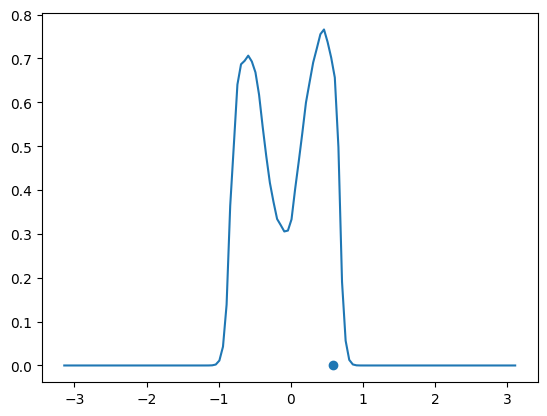

In [242]:
import matplotlib.pyplot as plt
plt.plot(thetas, jax.vmap(manip_fn)(jnp.vstack(val)))
plt.scatter(x[idx], 0)

array([-3.14159265, -3.04159265, -2.94159265, -2.84159265, -2.74159265,
       -2.64159265, -2.54159265, -2.44159265, -2.34159265, -2.24159265,
       -2.14159265, -2.04159265, -1.94159265, -1.84159265, -1.74159265,
       -1.64159265, -1.54159265, -1.44159265, -1.34159265, -1.24159265,
       -1.14159265, -1.04159265, -0.94159265, -0.84159265, -0.74159265,
       -0.64159265, -0.54159265, -0.44159265, -0.34159265, -0.24159265,
       -0.14159265, -0.04159265,  0.05840735,  0.15840735,  0.25840735,
        0.35840735,  0.45840735,  0.55840735,  0.65840735,  0.75840735,
        0.85840735,  0.95840735,  1.05840735,  1.15840735,  1.25840735,
        1.35840735,  1.45840735,  1.55840735,  1.65840735,  1.75840735,
        1.85840735,  1.95840735,  2.05840735,  2.15840735,  2.25840735,
        2.35840735,  2.45840735,  2.55840735,  2.65840735,  2.75840735,
        2.85840735,  2.95840735,  3.05840735])

In [807]:
# rotations: -1~1
# -1, 1

Array([ 0.00889851,  1.1274546 ,  0.36165857,  0.2601863 ,  0.46274334,
       -0.02354041,  0.63001865], dtype=float32)

Array([-0.440229  ,  2.041676  , -0.80095965], dtype=float32)

In [463]:
SO3.exp(x[3:])

SO3(wxyz=[ 0.43706998 -0.17701     0.82093    -0.32205   ])

In [95]:
val_manip(x)

Array(0.73762447, dtype=float32)

In [ ]:
panda_model.get_

In [30]:
frame.set_pose(SE3(panda_model.fk_fn(panda.neutral)[-1]))